# Car Decor Sales Forecasting Model - ANDROID HEADUNITS

###### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Connecting Python to MySQL for fetching data 
import mysql.connector

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

###### MySQL Connection to fetch data

In [3]:
try:
    connection = mysql.connector.connect(host='localhost',
                                        database='car_decors',
                                         user='root',
                                         password='Ankitsri17@')

    sql_select_Query = "SELECT * FROM decorsales"
    cursor = connection.cursor()
    cursor.execute(sql_select_Query)
    columns = len(cursor.description)
    columns = [i[0] for i in cursor.description]
    print(columns)

    # get all records
    records = cursor.fetchall()
    print("Total number of rows in table: ", cursor.rowcount)

except mysql.connector.Error as e:
    print("Error reading data from MySQL table", e)

Error reading data from MySQL table Authentication plugin 'caching_sha2_password' is not supported


### Data Cleaning and Exploratory Data Analysis

###### Converting fetched records to Pandas dataframe

In [3]:
records = np.array(records)
records = records[:,0:25]
decor_sales=pd.DataFrame(records,columns=columns)

###### Type Casting Date and other features

In [4]:
decor_sales.dtypes
decor_sales.Date = pd.to_datetime(decor_sales.Date)
decor_sales.iloc[:,1:] = decor_sales.iloc[:,1:].astype("int32")
decor_sales.dtypes

Date                 datetime64[ns]
AndroidHeadunits              int32
Speakers                      int32
Cameras                       int32
LeatherSeatCovers             int32
GLSteeringCovers              int32
7DMatts                       int32
3DMatts                       int32
Horns                         int32
Armrests                      int32
LedHeadlights                 int32
AlloyWheels                   int32
Spoilers                      int32
FancyGrills                   int32
ChromeAccessories             int32
RearGuards                    int32
SideBeading                   int32
BumperProtectors              int32
DoorGuards                    int32
DoorVisors                    int32
Sunfilm                       int32
Perfumes                      int32
LedFogLamps                   int32
Denting                       int32
Painting                      int32
dtype: object

###### Creating Subset of Decor Sales Dataset and resampling Monthly Time Series

In [ ]:
df = decor_sales
df = df.set_index('Date')
df = df.resample("MS").sum()

###### Data Visualization

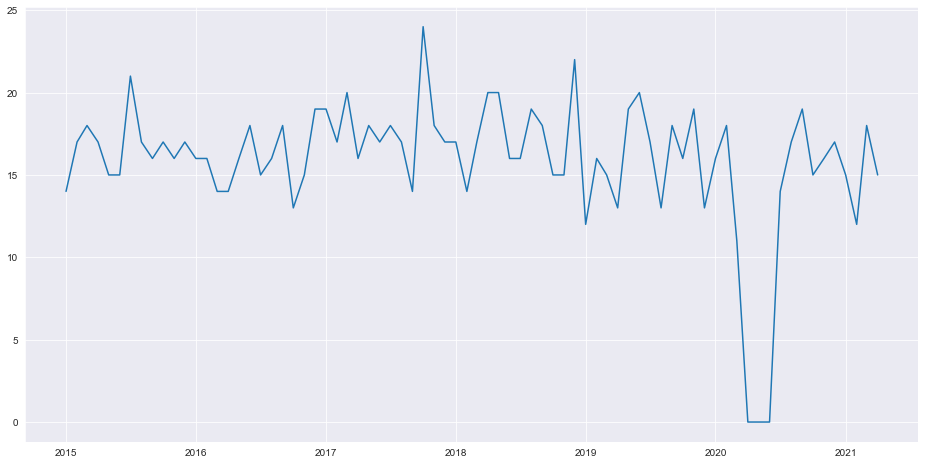

In [6]:
plt.rc("figure", figsize=(16,8))
sns.set_style('darkgrid')
plt.plot(df.index,df['AndroidHeadunits'])

###### Rolling statistics to observe variation in mean and standard deviation.

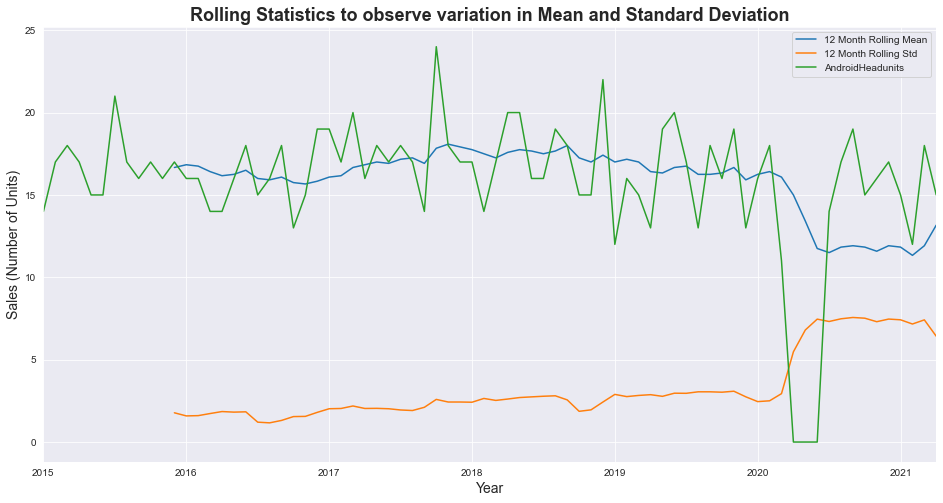

In [7]:
timeseries = df ['AndroidHeadunits']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.title('Rolling Statistics to observe variation in Mean and Standard Deviation', fontsize = 18, fontweight = 'bold')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Sales (Number of Units)', fontsize = 14)
plt.legend()

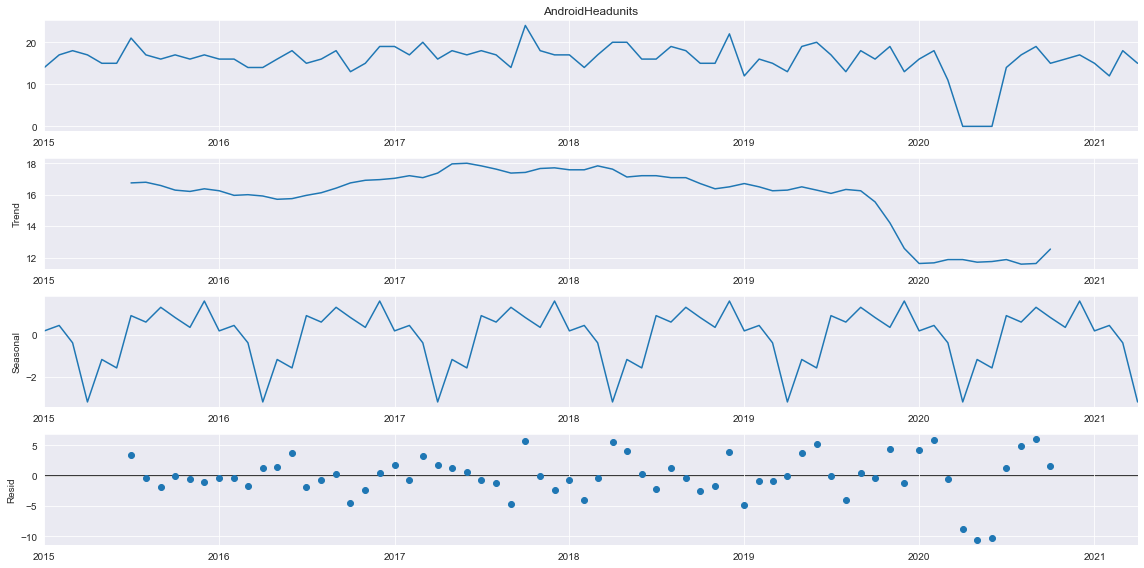

In [8]:
######################################################################
# Checking Seasonalty and Trend components for the feature
######################################################################
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

add = seasonal_decompose(df["AndroidHeadunits"],model="additive",period=12)
add.plot();

# Decomposition plot shows constant trend with noise in Qtr 2 - 2020 and seasonality is additive in nature.
# The data is seasonal and follows constant trend.
# Also, the average value or the mean of the residuals seem to be zero which holds our assumption.

In [9]:
######################################################################
# Checking for Data Stationarity using Augmented Dickey-Fuller Test
######################################################################

from statsmodels.tsa.stattools import adfuller

def check_adf(time_series):
    test_result = adfuller(df['AndroidHeadunits'])
    print ('ADF Test:')
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']

    for value,label in zip(test_result,labels):
        print (label+': '+str(value)+str("\n"))
        if test_result [1] <= 0.05:
            print ("Reject null hypothesis; Data is stationary")
        else:
            print ("Fail to reject H0; Data is non-stationary")
    
# If the data is non-stationary so we need to apply differencing to make our data stationary.
#df ['AndroidHeadunits'] = df ['AndroidHeadunits'] - df ['AndroidHeadunits']. shift (1)
#adf_check(df['AndroidHeadunits'].dropna())
#If again data is non-stationary we need to differencing with subsequent shifts.

check_adf(df['AndroidHeadunits'])

# By looking at adfuller test result we conclude that we need to differencing by 2 shifts to make our data stationary.

ADF Test:
ADF Statistic: -4.8674042089418705

Reject null hypothesis; Data is stationary
p-value: 4.034385999013513e-05

Reject null hypothesis; Data is stationary
No. of Lags Used: 0

Reject null hypothesis; Data is stationary
Number of Observations Used: 75

Reject null hypothesis; Data is stationary


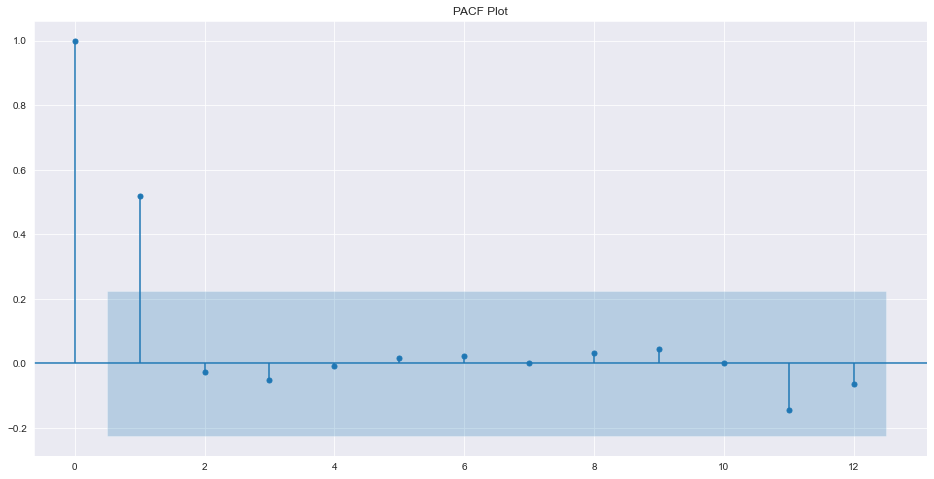

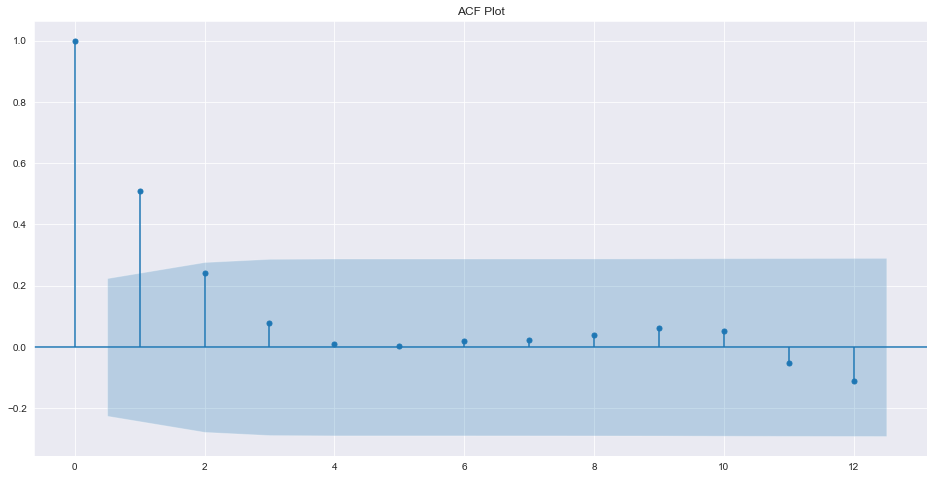

In [10]:
# Hyper-parameter Tuning
# Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# By looking at ACF pot and PACF plot we decide the value p(Auto regressive) and q(Moving average)
# p = sudden shuts off in pacf plot.
# q = Exponential drop in acf plot.
# d = degree of differencing/shift by adfuller test

#Auto Regressive (p)
# Identification of an AR model is often best done with the PACF.
# For an AR model, the theoretical PACF “shuts off” past the order of the model. 
# The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. 
# Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.
# By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

# Integration (d)
# Integration paramter is choosen through  how much value you have differentiated from original
# For a stationary data its either be 0 or 1

# Moving Average (q) 
# the theoretical PACF does not shut off, but instead tapers or exponetially decrease toward 0 in some manner.
# A clearer pattern for an MA model is in the ACF.
# The ACF will have non-zero autocorrelations only at lags involved in the model.

plot_pacf(df["AndroidHeadunits"], lags=12, title = 'PACF Plot');
plot_acf(df["AndroidHeadunits"], lags=12, title = 'ACF Plot');

In [11]:
######################################################################
######################################################################
# SARIMA Model (seasonal arima model)
# AR-Auto regressive,I-Intigrations, & MA-Moving average
# p for AR Components, q for MA comoponent and d parameter stands for degree of integration or differentiation
# which can be known from pacf and acf plot but reading these plots are required good amount of technical knowladge
# so here we are going with costume Automated parameter tuning
######################################################################
######################################################################

# Train Test Split 
train_df = df["AndroidHeadunits"].iloc[0:int(len(df)*.95)] #train model with approx 95% data
test_df = df["AndroidHeadunits"].iloc[int(len(train_df)):] #test model with 5% data

print("Train_df : ",len(train_df))
print("Test_df : ",len(test_df))

Train_df :  72
Test_df :  4


<AxesSubplot:xlabel='Date'>

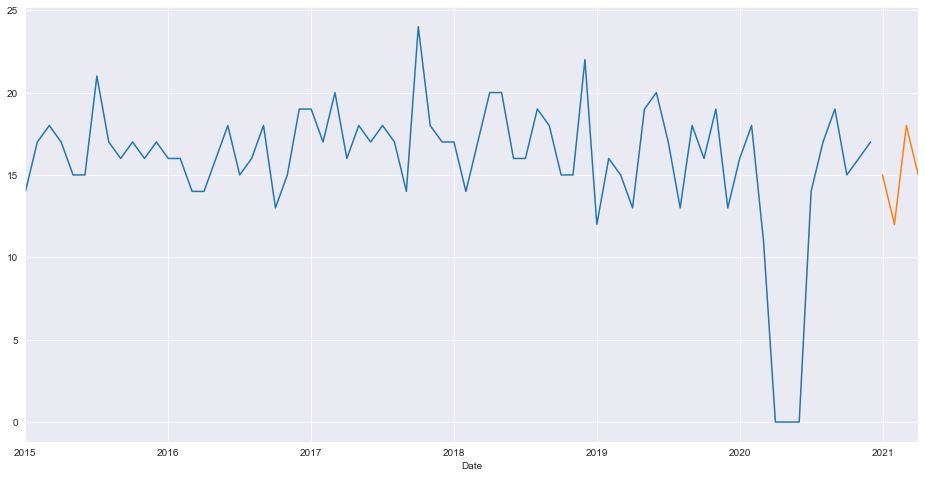

In [12]:
# Plotting the data
train_df.plot()
test_df.plot()

In [13]:
# Creating a function to calculate the MAPE value for test data 
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
# Automated Hyperparameter tuning 
import itertools as i 
p = range(0,3) 
d = range(0,1)
q = range(0,3)

pdq_combo = list(i.product(p,d,q)) #this will all combination of p,d,q throgh a tuple 

error = []
aic_sarima = []
order_arima = []
order_sarima = []
seasonality = 12
for pdq in pdq_combo:
    for PDQ in pdq_combo:
        try:
            SEASONAL_ORDER = list(PDQ)
            SEASONAL_ORDER.append(seasonality)
            model = sm.tsa.SARIMAX(train_df,order=(pdq),seasonal_order=tuple(SEASONAL_ORDER))
            result = model.fit(disp=0)
            pred = result.predict(start=len(train_df),end=len(df)-1)
            eror = mape(test_df,pred)
            aic_sarima.append(result.aic)
            order_arima.append(pdq)
            order_sarima.append(tuple(SEASONAL_ORDER))
            error.append(eror)
        except:
            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [15]:
# Creating a dataframe of seasonality orders and errors 
df_error = pd.DataFrame({"arima_order":order_arima,"sarima_order": order_sarima,"error":error,"aic":aic_sarima})
df_error = df_error.sort_values(by="error",ascending = True)
df_error.reset_index(inplace=True,drop=True)

In [16]:
## best parameter selection
p_d_q = df_error.iloc[0,0] #choosing best parameter for arima order
P_D_Q = df_error.iloc[0,1] #choosing best parameter for seasonal  order

In [17]:
## best parameter selection
print("Best p_d_q parameter : ", p_d_q)
print("Best P_D_Q parameter : ", P_D_Q)

Best p_d_q parameter :  (0, 0, 2)
Best P_D_Q parameter :  (2, 0, 1, 12)


In [18]:
# Model with best parameter
sarima_model = sm.tsa.SARIMAX(train_df, order=(p_d_q), seasonal_order=(P_D_Q))
results = sarima_model.fit(disp = 0)
pred = results.predict(start=test_df.index[0],end=test_df.index[-1])
pred_large = results.predict(start=75,end=83,dynamic=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


                                      SARIMAX Results                                       
Dep. Variable:                     AndroidHeadunits   No. Observations:                   72
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                -214.409
Date:                              Fri, 23 Jul 2021   AIC                            440.817
Time:                                      18:47:28   BIC                            454.477
Sample:                                  01-01-2015   HQIC                           446.256
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6512      0.097      6.680      0.000       0.460       0.842
ma.L2          0.37

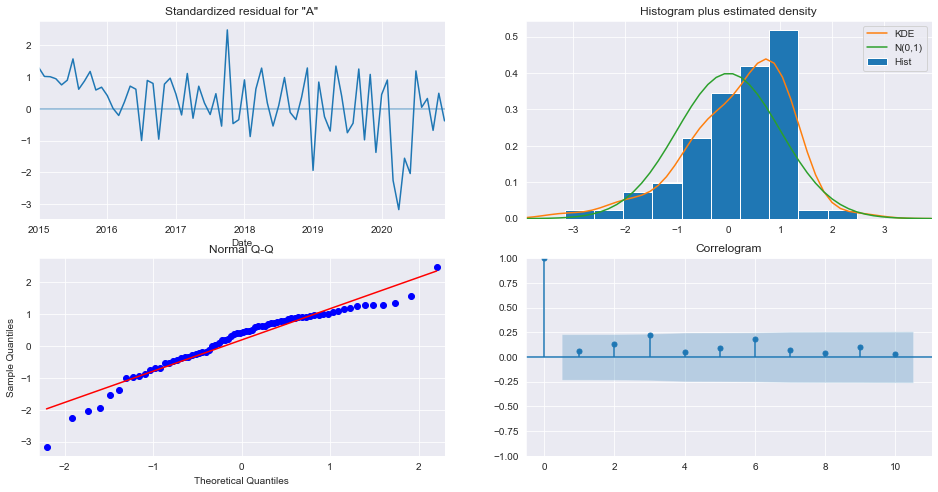

In [19]:
print(results.summary())
diagnostics = results.plot_diagnostics(figsize=(16,8))

In [20]:
# Insights from these diagnostic plot :
# 1.The top left plot shows the residuals over time.
# The plot shows our residuals are fluctuating around mean 0 there is uniform deviation over time
# except some noise in second quarter of 2021 due to lockdown imposed by government with effect of COVID-19 pandemic.

# 2.In the top-right plot,
# We see that the KDE follows closely with the N(0,1) line to indicate that the residuals are normally distributed. 
# This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.
# In our plot residuals are normally distributed.

# 3.In the bottom left qq-plot,
# We see the ordered distribution of residuals(blue dots) following the linear trend(red line)
# of the samples taken from a standard normal distribution with N(0, 1).

# 4.The autocorrelation visual (called a “correlogram”) on the bottom right shows that-
# The time series residuals have a low correlation with the lagged versions of itself 
# (that is, the majority of dots fall into the blue shaded area).

In [21]:
# Predicted values
# Point estimation
pred = results.get_prediction(start = test_df.index[0], end = test_df.index[-1], dynamic = True, full_results = True)
point_estimation = pred.predicted_mean
point_estimation

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-01-01    14.875560
2021-02-01    14.876818
2021-03-01    16.435197
2021-04-01    16.028981
Freq: MS, Name: predicted_mean, dtype: float64

In [22]:
#Checking MAPE
mape(test_df, point_estimation)

10.089074369450438

In [23]:
# At 95% confidence interval
pred_range = pred.conf_int(alpha = 0.05)
pred_range

,lower AndroidHeadunits,upper AndroidHeadunits
2021-01-01,7.503930,22.247190
2021-02-01,6.108694,23.644941
2021-03-01,7.258706,25.611688
2021-04-01,6.852489,25.205472


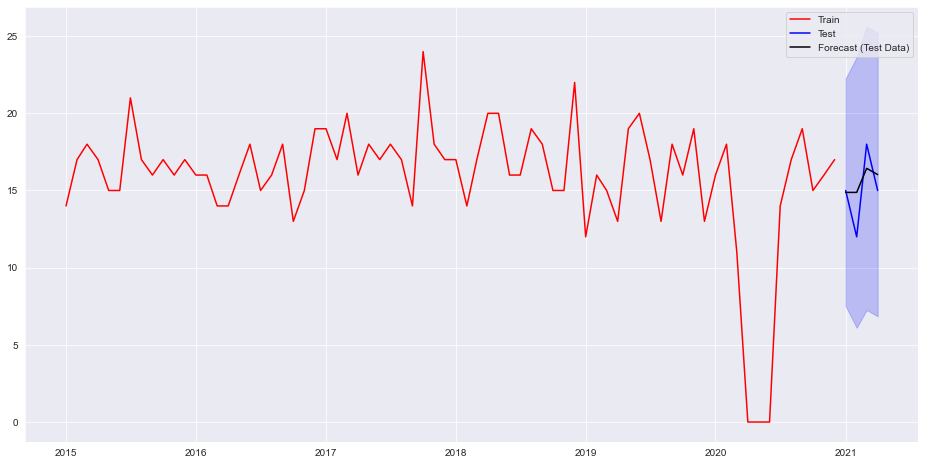

In [24]:
# Ploting final Sarima Prediction
plt.plot(train_df,color="r",label="Train")
plt.plot(test_df,color="b",label="Test")
plt.plot(point_estimation,color="black",label="Forecast (Test Data)")
plt.fill_between(pred_range.index,pred_range.iloc[:,0],pred_range.iloc[:,1],color='b',alpha=.2)
plt.legend(loc="upper right")

In [25]:
#Final sarima model on 100% data
sarima_model_final = sm.tsa.SARIMAX(df["AndroidHeadunits"], order=(p_d_q), seasonal_order=(P_D_Q))
results_final = sarima_model_final.fit(disp = 0)
pred_final = results_final.predict(start=test_df.index[0],end=test_df.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


                                      SARIMAX Results                                       
Dep. Variable:                     AndroidHeadunits   No. Observations:                   76
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                -224.207
Date:                              Fri, 23 Jul 2021   AIC                            460.414
Time:                                      18:47:33   BIC                            474.399
Sample:                                  01-01-2015   HQIC                           466.003
                                       - 04-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6311      0.091      6.903      0.000       0.452       0.810
ma.L2          0.38

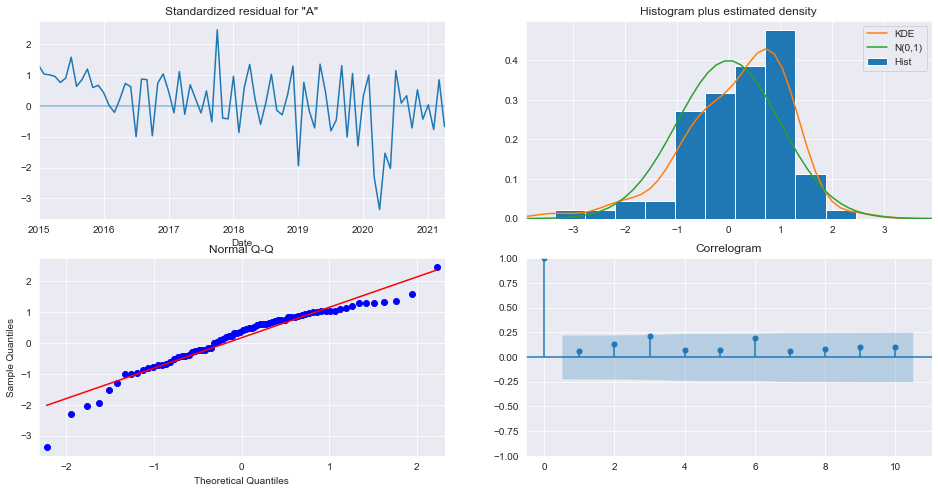

In [26]:
print(results_final.summary())
diagnostics = results_final.plot_diagnostics(figsize=(16,8))

In [27]:
pred_12 = results_final.get_prediction(start=75,end=86,dynamic=False)

# Point estimation
point_estimation_12 = pred_12.predicted_mean
point_estimation_12

2021-04-01    17.469745
2021-05-01    18.221767
2021-06-01    17.182488
2021-07-01    16.978357
2021-08-01    15.833920
2021-09-01    16.290352
2021-10-01    16.674270
2021-11-01    16.232419
2021-12-01    17.038190
Freq: MS, Name: predicted_mean, dtype: float64

In [28]:
# At 95% confidence interval
pred_range_12=pred_12.conf_int()
pred_range_12

,lower AndroidHeadunits,upper AndroidHeadunits
2021-04-01,10.298839,24.640651
2021-05-01,11.052366,25.391169
2021-06-01,8.704934,25.660041
2021-07-01,8.060176,25.896539
2021-08-01,6.915738,24.752102
2021-09-01,7.372171,25.208534
2021-10-01,7.756089,25.592452
2021-11-01,7.321461,25.143378
2021-12-01,8.146549,25.929832


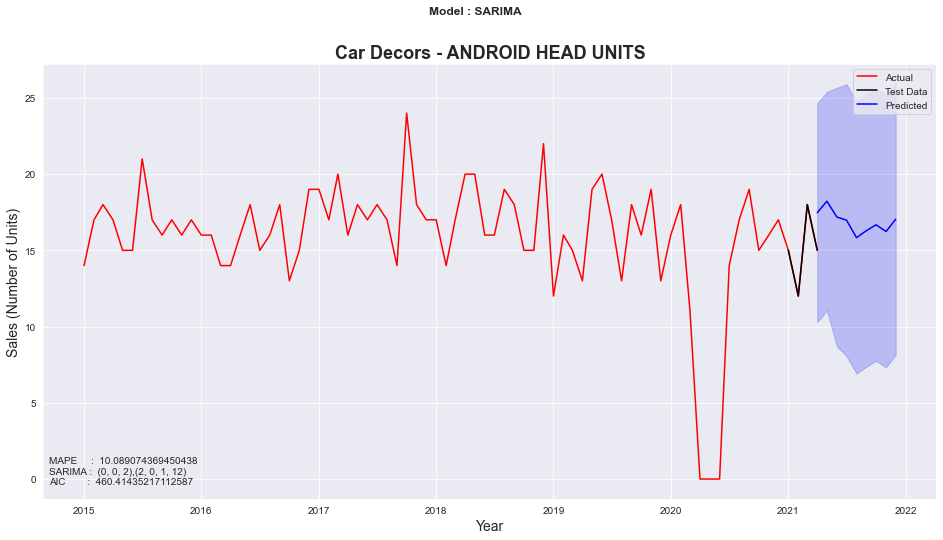

In [29]:
# Plotting sarima Final Model
plt.plot(df["AndroidHeadunits"],color="r",label="Actual")
plt.plot(df["AndroidHeadunits"].tail(4),color="black",label="Test Data")
plt.plot(point_estimation_12,color="b",label="Predicted")
plt.fill_between(pred_range_12.index,pred_range_12.iloc[:,0],pred_range_12.iloc[:,1],color='b',alpha=.2)
#plt.plot(pred_final,color="b",label="Forecast (Test Data)")
#plt.plot(pred_large_final_sarima,color="g",label="Forecast (12 Months)")
plt.suptitle('Model : SARIMA', fontsize = 12, fontweight = 'bold')
plt.title('Car Decors - ANDROID HEAD UNITS', fontsize = 18, fontweight = 'bold')
plt.figtext(0.13, 0.15, '\nMAPE     :  {} \nSARIMA :  {},{} \nAIC        :  {}'.format(mape(test_df, point_estimation), p_d_q, P_D_Q, results_final.aic, fontsize = 11))
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Sales (Number of Units)', fontsize = 14)
plt.legend(loc="best")

In [30]:
##################################################################################
##################################################################################
# Holt Winters Exponential Smoothing with Additive Seasonality and Additive Trend
##################################################################################
##################################################################################

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 

hwe_model_add_add = ExponentialSmoothing(train_df, seasonal = "add", trend = "add", seasonal_periods = 12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = test_df.index[0], end = test_df.index[-1])
mape(test_df, pred_hwe_add_add) 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


15.501293343307838

In [31]:
# Final Holt Winter's Model on 100% Data
hwe_model_add_final = ExponentialSmoothing(df["AndroidHeadunits"], seasonal = "add", trend = "add", seasonal_periods=12).fit()
pred_hwe_add_final = hwe_model_add_add.predict(start = test_df.index[0], end = test_df.index[-1])
pred_hwe_add_final_prediction = hwe_model_add_final.predict(start = 75, end = 86)
mape(test_df, pred_hwe_add_final) 

15.501293343307838

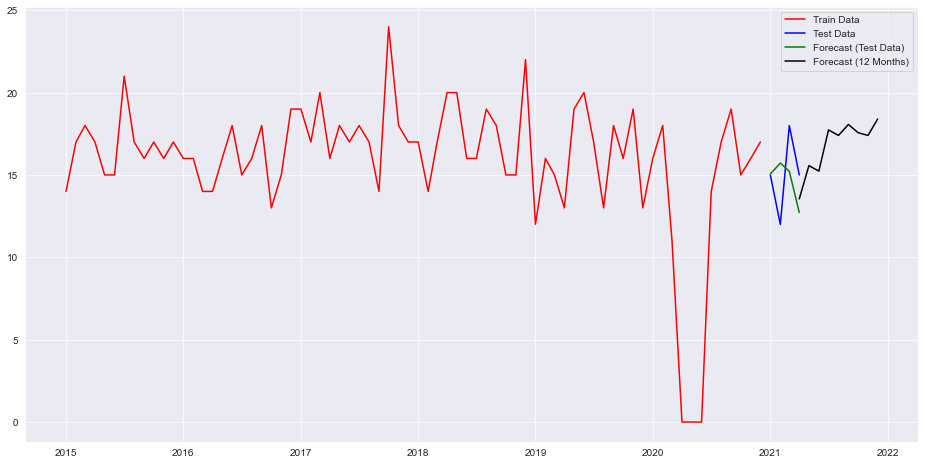

In [32]:
# Ploting Train_Test Prediction
plt.plot(train_df,color="r",label="Train Data")
plt.plot(test_df,color="b",label="Test Data")
plt.plot(pred_hwe_add_final,color="g",label="Forecast (Test Data)")
plt.plot(pred_hwe_add_final_prediction,color="black",label="Forecast (12 Months)")
plt.legend(loc="best")

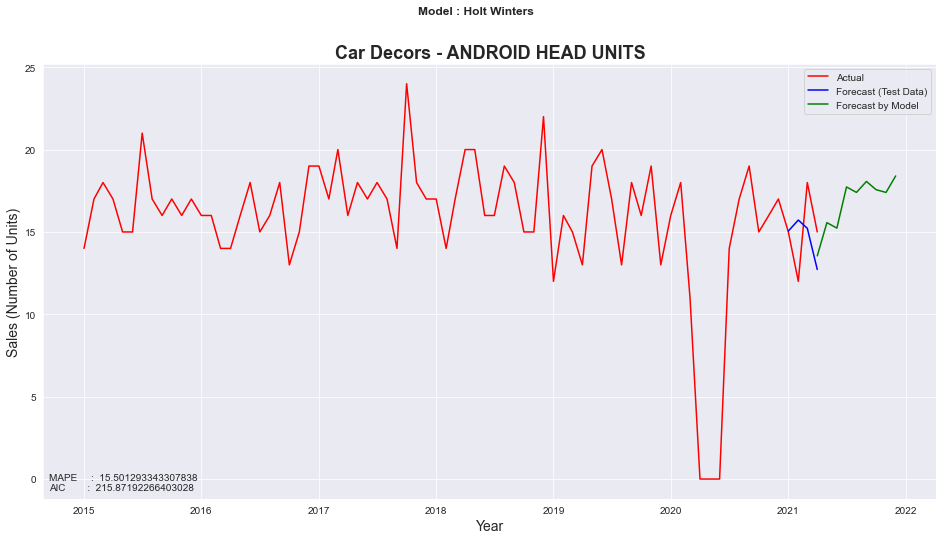

In [33]:
# Plotting Final Model
plt.plot(df["AndroidHeadunits"],color="r",label="Actual")
plt.plot(pred_hwe_add_final,color="b",label="Forecast (Test Data)")
plt.plot(pred_hwe_add_final_prediction,color="g",label="Forecast by Model")
plt.suptitle('Model : Holt Winters', fontsize = 12, fontweight = 'bold')
plt.title('Car Decors - ANDROID HEAD UNITS', fontsize = 18, fontweight = 'bold')
plt.figtext(0.13, 0.14, '\nMAPE     :  {} \nAIC        :  {}'.format(mape(test_df, pred_hwe_add_add), hwe_model_add_add.aic))
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Sales (Number of Units)', fontsize = 14)
plt.legend(loc="best")

In [34]:
forecast = hwe_model_add_final.predict(start = 75, end = 86)
forecast

2021-04-01    13.546911
2021-05-01    15.565396
2021-06-01    15.232023
2021-07-01    17.732036
2021-08-01    17.398663
2021-09-01    18.065353
2021-10-01    17.565330
2021-11-01    17.398650
2021-12-01    18.398659
Freq: MS, dtype: float64

In [35]:
######################################################################
# Models Evaluation
######################################################################
from sklearn.metrics import mean_squared_error as mse
print("\nSARIMA Trend          :  ", p_d_q)
print("SARIMA Seasonal Order :  ", P_D_Q)
print("SARIMA AIC            :  ", results.aic)
print("SARIMA RMSE           :  ", np.sqrt(mse(test_df,point_estimation)))
print("SARIMA MAPE           :  ", mape(test_df, point_estimation))
print("\nHolt Winters AIC      :  ", hwe_model_add_final.aic)
print("Holt Winters RMSE     :  ", np.sqrt(mse(test_df,pred_hwe_add_final)))
print("Holt Winters MAPE     :  ", mape(test_df, pred_hwe_add_final))


SARIMA Trend          :   (0, 0, 2)
SARIMA Seasonal Order :   (2, 0, 1, 12)
SARIMA AIC            :   440.8174804852521
SARIMA RMSE           :   1.717481692028152
SARIMA MAPE           :   10.089074369450438

Holt Winters AIC      :   224.76055206463352
Holt Winters RMSE     :   2.586696880826467
Holt Winters MAPE     :   15.501293343307838


In [36]:
######################################################################
# Saving SARIMA Model
######################################################################
import pickle
sarima_filename = 'C:/Users/Maqbool/Downloads/SARIMA_HW/Models/sarima_ahu.sav'
pickle.dump(sarima_model_final, open(sarima_filename, 'wb'))

hw_filename = 'C:/Users/Maqbool/Downloads/SARIMA_HW/Models/holtwinters_ahu.sav'
pickle.dump(hwe_model_add_final, open(hw_filename, 'wb'))

In [37]:
from time import time
def exec_time(file_name,):
    start = time()
    file_name = file_name
    fileobj = open(file_name,'rb')
    load_model = pickle.load(fileobj)
    end = time()
    return  end-start

                                      SARIMAX Results                                       
Dep. Variable:                     AndroidHeadunits   No. Observations:                   76
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                -224.207
Date:                              Fri, 23 Jul 2021   AIC                            460.414
Time:                                      18:49:36   BIC                            474.399
Sample:                                  01-01-2015   HQIC                           466.003
                                       - 04-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7343      0.009     83.712      0.000       0.717       0.752
ma.L2          0.48

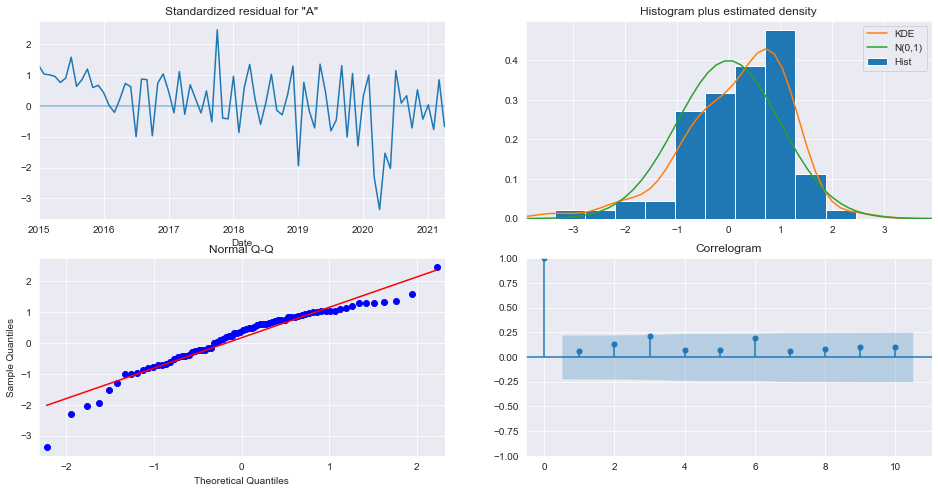

In [44]:
####### Model summary and diagnstics plot #######

exec_time(sarima_filename) # execution time
fileobj = open(sarima_filename,'rb')
load_model = pickle.load(fileobj)

result = load_model.fit()
print(result.summary())
diagnostics = result.plot_diagnostics(figsize=(16,8))

In [45]:
# Predicted values
# Point estimation
pred = result.get_prediction(start = test_df.index[0], end = test_df.index[-1], dynamic = True, full_results = True)
point_estimation = pred.predicted_mean
point_estimation

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Date
2021-01-01    14.890355
2021-02-01    14.757036
2021-03-01    16.674926
2021-04-01    16.626868
Freq: MS, Name: predicted_mean, dtype: float64

In [46]:
# At 95% confidence interval
pred_range = pred.conf_int()
pred_range

,lower AndroidHeadunits,upper AndroidHeadunits
Date,,
2021-01-01,7.690665,22.090046
2021-02-01,-17.000506,46.514578
2021-03-01,-22.413403,55.763255
2021-04-01,-25.196724,58.450459


In [47]:
pred_large = result.predict(start=75,end=86,dynamic=True)
pred_large

2021-04-01    17.469745
2021-05-01    19.780111
2021-06-01    18.136020
2021-07-01    16.978357
2021-08-01    15.833920
2021-09-01    16.290352
2021-10-01    16.674270
2021-11-01    16.229634
2021-12-01    17.031633
Freq: MS, Name: predicted_mean, dtype: float64

In [48]:
# checking error
mape(test_df, point_estimation)

10.478392784658919

In [49]:
#####################################################################
# Closing connection to MySQL and clearning variables from memory.
#####################################################################

if connection.is_connected():
    connection.close()
    cursor.close()
    print("MySQL connection is closed")

    #Clear all variables from memory
    globals().clear()

#####################################################################

MySQL connection is closed
